## 6.1 使用Model Function API建立各種非線性堆疊網路

   傳統線性堆疊的神經網路存在前一層的單一輸入，並輸出到後面的單一層。
   但在非線性堆疊網路常見可分為：
    - 合併(merge)結構：輸入來自多層的神經網路層的合併結果。
    - 分歧(branch)結構：單層神經網路輸出至不同層的神經網路。

## (1)初始準備

In [2]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Keras function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Keras datasets
from keras.datasets import mnist

#Keras utilis function
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) =mnist.load_data()

In [6]:
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)

In [7]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [8]:
y_train=np_utils.to_categorical(y_train,10)
y_test=np_utils.to_categorical(y_test,10)

## (2) Model Function API

* 多重輸入-多重輸出模型(Multi-input and multi-output models)
    - 合併(merge)
    - 分歧(branch)
* 具重複/循環結構的模型，如CycleGAM

In [9]:
from keras.models import Model
from keras.layers import Input

### Model Function API的操作方式

1. 把每層神經網路層當作函數來定義
2. 透過層函數將變數連結
3. 定義神經網路的輸入與輸出

In [13]:
f_1=Dense(500,activation='sigmoid')
f_2=Dense(500,activation='sigmoid')
f_3=Dense(10,activation='softmax')         

In [14]:
print(f_1)

In [16]:
x = Input(shape=(784,))

In [17]:
print(x)

Tensor("input_1:0", shape=(None, 784), dtype=float32)


In [22]:
h_1 = f_1(x)
h_2 = f_2(h_1)
y = f_3(h_2)

In [23]:
print(h_1)
print(h_2)
print(y)

Tensor("dense_1_2/Sigmoid:0", shape=(None, 500), dtype=float32)
Tensor("dense_2_3/Sigmoid:0", shape=(None, 500), dtype=float32)
Tensor("dense_3_1/Softmax:0", shape=(None, 10), dtype=float32)


In [25]:
model= Model(x,y)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',optimizer=SGD(lr=0.1),
             metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=100, epochs=20)

* 檢驗模型架構是否一致

In [ ]:
# 方法一：讀入以前儲存的權重，如無誤則一致
model.load_weights('handwriting_model_weights.h5')

In [ ]:
# 方法二：再使用測試資料檢驗訓練結果的正確率是否一致
model.evaluate(x_test, y_test)

## 6.2 非線性堆疊模型如何建立？
範例：增加f4(改用relu)並改變f3
![範例](6_1.jpg)

In [26]:
from keras.layers import concatenate, add

In [29]:
f_4 = Dense(500, activation='relu')
z = f_4(h_1)

# new f_3
f_3 =Dense(10, activation= 'softmax')

# 將神經網路層合併送到最終的output層
u = concatenate([h_2, z])
y = f_3(u)

In [31]:
print(u)
print(y)

Tensor("concatenate_3/concat:0", shape=(None, 1000), dtype=float32)
Tensor("dense_9/Softmax:0", shape=(None, 10), dtype=float32)


In [33]:
model = Model(x,y)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          250500      dense_1[2][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 500)          250500      dense_1[2][0]                    
____________________________________________________________________________________________

## 小結論

注意要點：
1. 每一層分別定義成函數
2. 分歧結構：透過新的函數定義新的變數
3. 合併結構：合併前要將所有變數合併在一起，才能進行後續運算

常見運用：
1. 多重輸入-多重輸出模型
2. 當函數為convolution，這樣的技巧可實現U-net的重要結構multi-resolution(多解析度融合，MRF)
3. ResNet上的重要結構skip connection(跳躍式傳遞)，亦可透過分歧-合併實現，差別在於該模型使用'add'

## 6.3 具平均功能的神經網路

* 介紹自定義不具訓練權重的神經網路層(也存在具有訓練權重的神經網路，但較為複雜)
   -  除了NN、CNN、RNN外，如何將常見運算作為神經網路的某層運算

In [78]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [79]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input

from keras.layers.core import Lambda
from keras import backend as K

以下定義僅接受tensorflow輸入

In [14]:
def average_function(inputs):
    return K.mean(inputs, axis=1)

In [15]:
average_layers = Lambda(average_function)

In [16]:
print(average_layers)

In [17]:
inputSize = 4

x = Input(shape=(inputSize,))
y = average_layers(x)
average_model= Model(x,y)

In [19]:
average_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None,)                   0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [20]:
average_model.compile(loss='mse', optimizer='sgd')

In [22]:
np.array([[1,2,3,4]]).shape

(1, 4)

In [24]:
average_model.predict(np.array([[1,2,3,4],[1,1,1,1]]))

array([2.5, 1. ], dtype=float32)

## 6.4 具抽樣功能的神經網路

- 輸入為兩個n維向量(U1,...,Un, S1,...,Sn)
- U代表n維常態分配的平均數，S代表變異數取log(為了讓該值可正、可負)，即是log-variance
- 即是神經網路輸出符合 $N(u , e^s ln)$ 的n維向量


In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input

from keras.layers.core import Lambda
from keras import backend as K

Using TensorFlow backend.


In [3]:
sampling_dim = 2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(sampling_dim,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
sample_layer = Lambda(sampling, output_shape=(sampling_dim,))

In [5]:
m = Input(shape=(sampling_dim,))
s = Input(shape=(sampling_dim,))

z = sample_layer([m, s])

sample_model = Model([m, s], z)

In [6]:
sample_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [7]:
test_mean = np.random.randint(10, size=sampling_dim).reshape(1, 2)
test_log_var = np.array([[0, 0]])

print("平均為 (%d, %d)" %(test_mean[0][0], test_mean[0][1]))

平均為 (3, 9)


二維常態分配其平均數為(7,4)，且log-variance為(0,0)

In [14]:
####該段語法無法成功運作####
sample_model.predict([test_mean, test_log_var])

array([[4.0688057, 9.136351 ]], dtype=float32)

### 跟Numpy的抽樣函數比較

In [58]:
num_of_samples = 100

In [59]:
np_sample = np.random.multivariate_normal(test_mean[0], np.identity(2), size=num_of_samples)

In [60]:
keras_sample = np.zeros((num_of_samples,2))
for i in range(num_of_samples):
    keras_sample[i] = sample_model.predict([test_mean, test_log_var])

Text(0.5, 1.0, 'Normal Random Sampling using Keras/Numpy')

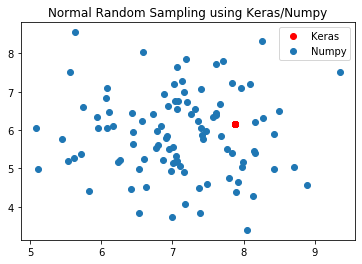

In [61]:
plt.plot(keras_sample[:,0], keras_sample[:,1], 'ro')
plt.plot(np_sample[:,0], np_sample[:,1], 'o')
plt.legend(['Keras', 'Numpy'])
plt.title('Normal Random Sampling using Keras/Numpy')

## 6.5 完成所有建立Variational Autoencoder所需技巧
- 分歧-合併模型
- 自定義函數